In [1]:
# MSCI 546 Project:

# Link to the original Kaggle Competition (Real Dataset): https://www.kaggle.com/code/kmalit/bank-customer-churn-prediction

In [2]:

# Libraries

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch  # Main torch import for torch tensors
import torch.nn as nn  # Neural network module for building deep learning models
import torch.optim as optim  # Optimization module

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [3]:
# Synthetic Dataset: https://www.kaggle.com/competitions/playground-series-s4e1/data

# Dataset import
import os
# Set directory to project root
os.chdir('/Users/danazarezankova/Documents/BME 2024/BME 4B/MSCI 546/msci-546-proj')

# Back to root directory
synthetic_train_data = pd.read_csv('data/train.csv')

synthetic_train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
synthetic_train_data.shape

(165034, 14)

In [5]:
# Label encoding for text data:
encoder = LabelEncoder()
categorical_features_train = synthetic_train_data.select_dtypes(include = 'object').columns
print("Categorical features: ", categorical_features_train)
for feature in categorical_features_train:
    synthetic_train_data[feature] = encoder.fit_transform(synthetic_train_data[feature])

# MinMax Scaler for credit score
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
synthetic_train_data['CreditScore'] = scaler.fit_transform(synthetic_train_data[['CreditScore']])

# Robust Scaler for Balance
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
synthetic_train_data['Balance'] = scaler.fit_transform(synthetic_train_data[['Balance']])

# MinMax Scaler for Estimated Salary
scaler = MinMaxScaler()
synthetic_train_data['EstimatedSalary'] = scaler.fit_transform(synthetic_train_data[['EstimatedSalary']])

# Age / 100
synthetic_train_data['Age'] = synthetic_train_data['Age'] / 100

synthetic_train_data.drop('id', axis=1, inplace=True)
synthetic_train_data.drop('CustomerId', axis=1, inplace=True)
synthetic_train_data.drop('Surname', axis=1, inplace=True)
synthetic_train_data.dropna(inplace=True)

X = synthetic_train_data.drop('Exited', axis=1)
y = synthetic_train_data['Exited']


Categorical features:  Index(['Surname', 'Geography', 'Gender'], dtype='object')


In [6]:
X.describe()


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,0.612909,0.648545,0.564429,0.381259,5.020353,0.462551,1.554455,0.753954,0.497770,0.562870
std,0.160207,0.816574,0.495833,0.088672,2.806159,0.523745,0.547154,0.430707,0.499997,0.251488
min,0.000000,0.000000,0.000000,0.180000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.494000,0.000000,0.000000,0.320000,3.000000,0.000000,1.000000,1.000000,0.000000,0.373166
50%,0.618000,0.000000,1.000000,0.370000,5.000000,0.000000,2.000000,1.000000,0.000000,0.589738
75%,0.720000,1.000000,1.000000,0.420000,7.000000,1.000000,2.000000,1.000000,1.000000,0.775779
max,1.000000,2.000000,1.000000,0.920000,10.000000,2.091872,4.000000,1.000000,1.000000,1.000000


In [7]:
# Convert the data to PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Add normalization to the model

model = nn.Sequential(
    nn.Linear(10, 20), 
    nn.BatchNorm1d(20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.BatchNorm1d(20),
    nn.ReLU(),   
    nn.Linear(20, 10),
    nn.BatchNorm1d(10),
    nn.ReLU(), 
    nn.Linear(10, 1), 
    nn.Sigmoid() 
)

In [10]:
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [11]:
n_epochs = 100
batch_size = 1028

train_accuracies = []

model.train()
for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        y_pred = model(X)
        y_pred = y_pred.round().detach().numpy()
        accuracy = accuracy_score(y, y_pred)
        print(f'Epoch {epoch}, loss {loss}, accuracy {accuracy}')
        train_accuracies.append(accuracy)
    print(f'Finished epoch {epoch}, latest loss {loss}')

Epoch 0, loss 0.31218773126602173, accuracy 0.8588472678357187
Finished epoch 0, latest loss 0.31218773126602173
Finished epoch 1, latest loss 0.307505339384079
Finished epoch 2, latest loss 0.30810368061065674
Finished epoch 3, latest loss 0.3032136857509613
Finished epoch 4, latest loss 0.3044930696487427
Finished epoch 5, latest loss 0.3043017089366913
Finished epoch 6, latest loss 0.30253109335899353
Finished epoch 7, latest loss 0.2986683249473572
Finished epoch 8, latest loss 0.29790356755256653
Finished epoch 9, latest loss 0.296174019575119
Epoch 10, loss 0.2964087128639221, accuracy 0.8647309039349468
Finished epoch 10, latest loss 0.2964087128639221
Finished epoch 11, latest loss 0.29472336173057556
Finished epoch 12, latest loss 0.2962273955345154
Finished epoch 13, latest loss 0.292405366897583
Finished epoch 14, latest loss 0.2937619388103485
Finished epoch 15, latest loss 0.29288870096206665
Finished epoch 16, latest loss 0.29128390550613403
Finished epoch 17, latest loss

In [12]:
with torch.no_grad():
  y_pred_test = model(X_test)

y_pred_50 = y_pred_test.round().detach().numpy()
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_50)
print(f'Accuracy of the deep NN model with normalization (50% threshold): {accuracy}')

Accuracy of the deep NN model with normalization (50% threshold): 0.8680279940618657


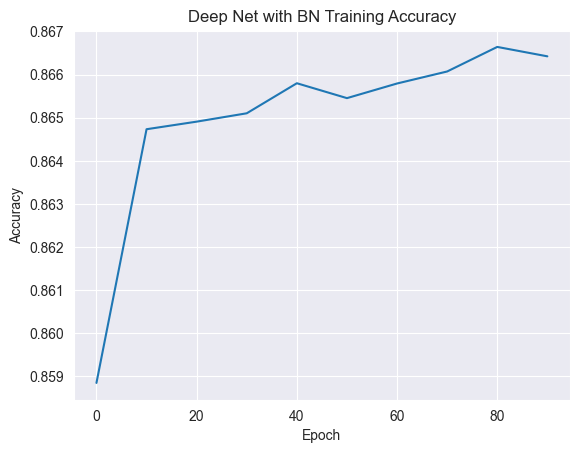

In [13]:
# Plot the training accuracy
plt.plot(range(0,100, 10), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Deep Net with BN Training Accuracy')
plt.show()

In [14]:
# Train for 500 epochs to see when the model converges
# Add normalization to the model

model = nn.Sequential(
    nn.Linear(10, 20), 
    nn.BatchNorm1d(20),
    nn.ReLU(),
    nn.Linear(20, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    nn.Linear(40, 40),
    nn.BatchNorm1d(40),
    nn.ReLU(),
    nn.Linear(40, 20),
    nn.BatchNorm1d(20),
    nn.ReLU(),   
    nn.Linear(20, 10),
    nn.BatchNorm1d(10),
    nn.ReLU(), 
    nn.Linear(10, 1), 
    nn.Sigmoid() 
)

loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

n_epochs = 500
batch_size = 1028

train_accuracies = []

model.train()
for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        y_pred = model(X)
        y_pred = y_pred.round().detach().numpy()
        accuracy = accuracy_score(y, y_pred)
        print(f'Epoch {epoch}, loss {loss}, accuracy {accuracy}')
        train_accuracies.append(accuracy)
    print(f'Finished epoch {epoch}, latest loss {loss}')

Epoch 0, loss 0.30682116746902466, accuracy 0.8572475974647649
Finished epoch 0, latest loss 0.30682116746902466
Finished epoch 1, latest loss 0.30496054887771606
Finished epoch 2, latest loss 0.30271467566490173
Finished epoch 3, latest loss 0.3024139106273651
Finished epoch 4, latest loss 0.29992300271987915
Finished epoch 5, latest loss 0.29663553833961487
Finished epoch 6, latest loss 0.29675573110580444
Finished epoch 7, latest loss 0.2967595160007477
Finished epoch 8, latest loss 0.2960939109325409
Finished epoch 9, latest loss 0.2955717146396637
Epoch 10, loss 0.29288387298583984, accuracy 0.8646884884326866
Finished epoch 10, latest loss 0.29288387298583984
Finished epoch 11, latest loss 0.2933802008628845
Finished epoch 12, latest loss 0.29448598623275757
Finished epoch 13, latest loss 0.29280203580856323
Finished epoch 14, latest loss 0.29074475169181824
Finished epoch 15, latest loss 0.29065266251564026
Finished epoch 16, latest loss 0.2904415428638458
Finished epoch 17, lat

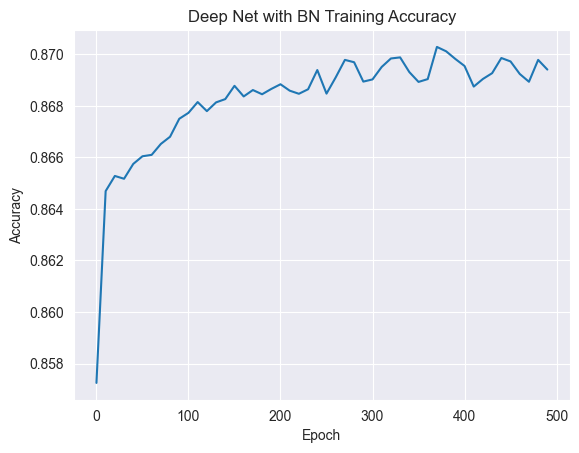

In [15]:
# Plot train accuracies
plt.plot(range(0,500, 10), train_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Deep Net with BN Training Accuracy')
plt.show()

In [16]:
with torch.no_grad():
  y_pred_test = model(X_test)

y_pred_50 = y_pred_test.round().detach().numpy()
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_50)
print(f'Accuracy of the deep NN model with normalization (50% threshold): {accuracy}')

Accuracy of the deep NN model with normalization (50% threshold): 0.8696034174569031


AUC:  0.9024275123921266
Precision:  0.7534901510805125
Recall:  0.5664989216391085


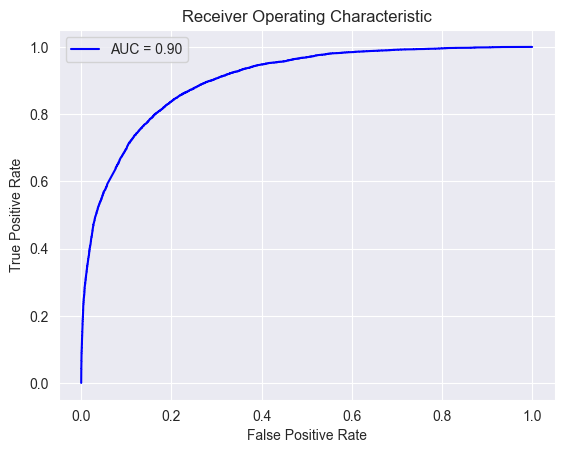

In [20]:
# Making the AUROC curve
import sklearn.metrics as metrics

tpr, fpr, thresholds = metrics.roc_curve(y_test, y_pred_test, pos_label=0)
roc_auc = metrics.auc(fpr, tpr)
print("AUC: ", roc_auc)

# Precision and recall:
precision = metrics.precision_score(y_test, y_pred_50)
recall = metrics.recall_score(y_test, y_pred_50)
print("Precision: ", precision)
print("Recall: ", recall)

# Plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Text(0.5, 427.9555555555555, 'Predicted label')

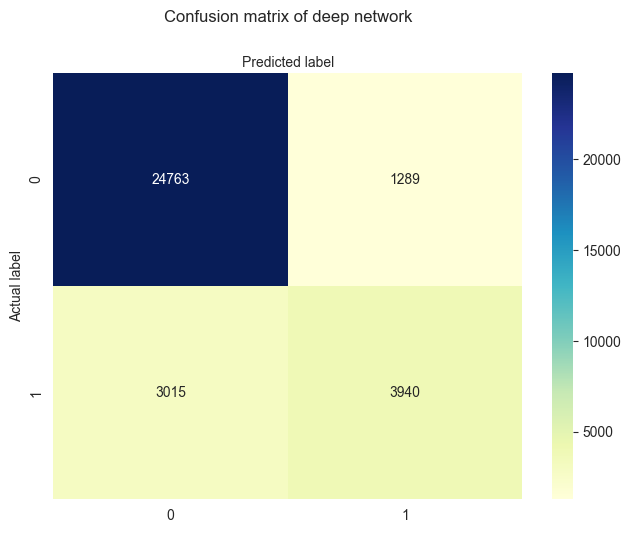

In [21]:
import sklearn.metrics as metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_50)

class_names=[0,1] # Names of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix of deep network', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')